# Temperature prediction with XGBoost

In [52]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from pathlib import Path
plt.style.use('seaborn-v0_8-whitegrid')

DATA_DIR = Path('data')

df = pd.read_csv(DATA_DIR / 'combined.csv', parse_dates=['time'], index_col='time')


In [53]:
def train_and_eval(data, target_col, model_name, test_days=365):
    train = data.iloc[:-test_days]
    test = data.iloc[-test_days:]

    X_train = train.drop(columns=[target_col])
    y_train = train[target_col]
    X_test = test.drop(columns=[target_col])
    y_test = test[target_col]

    model = xgb.XGBRegressor(
        n_estimators=1500,
        learning_rate=0.02,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8, # Tutaj bierzemy więcej cech (0.8) niż w multi, bo mamy ich mało
        random_state=42,
        n_jobs=-1,
        early_stopping_rounds=50
    )

    # Walidacja
    split = int(len(X_train) * 0.9)
    model.fit(
        X_train.iloc[:split], y_train.iloc[:split],
        eval_set=[(X_train.iloc[split:], y_train.iloc[split:])],
        verbose=0
    )

    preds = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)

    print(f"[{model_name}] RMSE: {rmse:.2f}°C | MAE: {mae:.2f}°C | R2: {r2:.4f}")

    return y_test, preds, model

In [65]:
def show_results(day_result, night_result):
    y_day, p_day, m_day = day_result
    y_night, p_night, m_night = night_result
    fig, ax = plt.subplots(2, 1, figsize=(12, 10))

    # Wykres Dnia
    subset = 60
    ax[0].plot(
        y_day.index[-subset:],
        y_day.values[-subset:],
        "o-",
        color="orange",
        label="Rzeczywista (Dzień)",
        alpha=0.6,
    )
    ax[0].plot(
        y_day.index[-subset:],
        p_day[-subset:],
        "x--",
        color="black",
        label="Prognoza Single",
    )
    ax[0].set_title("Prognoza Dnia")
    ax[0].legend()

    # Wykres Nocy
    ax[1].plot(
        y_night.index[-subset:],
        y_night.values[-subset:],
        "o-",
        color="navy",
        label="Rzeczywista (Noc)",
        alpha=0.6,
    )
    ax[1].plot(
        y_night.index[-subset:],
        p_night[-subset:],
        "x--",
        color="red",
        label="Prognoza Single",
    )
    ax[1].set_title("Prognoza Nocy")
    ax[1].legend()

    plt.tight_layout()
    plt.show()

### Targety na dzień i noc

Przewidujemy na następne pół doby:
- dzień:
  - bierzemy dane z przeszłości do 05:00 dzisiaj
  - i prognozujemy średnią na 06:00-18:00 dzisiaj
- noc:
  - bierzemy dane z przeszłości do 17:00 dzisiaj
  - i prognozujemy średnią na 18:00 dzisiaj do 06:00 jutro

In [55]:
def get_targets(df_raw):
    temp = df_raw[['temp']].copy()

    # Definicja okresów
    mask_day = (temp.index.hour >= 6) & (temp.index.hour <= 17)
    mask_night = (temp.index.hour >= 18) | (temp.index.hour <= 5)

    # 1. Target Dnia (Średnia 06:00 - 17:00 przypisana do daty)
    target_day = temp.loc[mask_day, 'temp'].resample('D').mean()
    target_day.name = 'target_temp_day'

    # 2. Target Nocy (Średnia 18:00 - 05:00 przypisana do daty wieczora)
    # Przesuwamy -6h, żeby noc 1/2 stycznia liczyła się do 1 stycznia
    temp_night_shifted = temp.loc[mask_night].copy()
    temp_night_shifted.index = temp_night_shifted.index - pd.Timedelta(hours=6)
    target_night = temp_night_shifted['temp'].resample('D').mean()
    target_night.name = 'target_temp_night'

    return target_day, target_night

series_day_target, series_night_target = get_targets(df)

### XGBoost tylko dla danych z Wrocławia

In [56]:
# 3. FEATURE ENGINEERING
def create_single_station_dataset(df_raw, snapshot_hour, target_series):
    print(f"Budowanie datasetu dla Snapshota: {snapshot_hour}:00 ---")

    # 1. Główny Snapshot (Moment startu prognozy)
    df_snap = df_raw[df_raw.index.hour == snapshot_hour].copy()
    df_snap.index = df_snap.index.normalize() # Data bez godziny

    # 2. Dane "Historyczne" (dla obliczenia trendów)
    # Pobieramy dane sprzed 3 godzin i sprzed 1 godziny
    # Uwaga: Musimy obsłużyć przejście przez północ (dla godziny 0-2),
    # ale zakładając snapshoty 06:00 i 18:00, wystarczy proste odjęcie godzin.

    lag_1h_idx = (snapshot_hour - 1)
    lag_3h_idx = (snapshot_hour - 3)

    df_lag1 = df_raw[df_raw.index.hour == lag_1h_idx].copy()
    df_lag3 = df_raw[df_raw.index.hour == lag_3h_idx].copy()

    # Normalizacja indeksów, żeby pasowały do df_snap
    df_lag1.index = df_lag1.index.normalize()
    df_lag3.index = df_lag3.index.normalize()

    # 3. Budowa Cech (X)
    X = pd.DataFrame(index=df_snap.index)

    # Stan Aktualny
    cols_current = ['temp', 'pres', 'rhum', 'wspd', 'cldc', 'prcp']
    for col in cols_current:
        if col in df_snap.columns:
            X[f'{col}_now'] = df_snap[col]

    # Fizyka: Trendy
    # Jak szybko zmienia się ciśnienie? (Ważne dla frontów)
    X['pres_trend_3h'] = df_snap['pres'] - df_lag3['pres']

    # Jak szybko zmienia się temperatura? (Dynamika nagrzewania/chłodzenia)
    X['temp_trend_1h'] = df_snap['temp'] - df_lag1['temp']
    X['temp_trend_3h'] = df_snap['temp'] - df_lag3['temp']

    # Punkt rosy (Dew Point)
    # Uproszczone przybliżenie: T - ((100 - RH)/5)
    X['dew_point_approx'] = X['temp_now'] - ((100 - X['rhum_now']) / 5)

    # --- Czas ---
    X['day_of_year_sin'] = np.sin(2 * np.pi * X.index.dayofyear / 365)
    X['day_of_year_cos'] = np.cos(2 * np.pi * X.index.dayofyear / 365)
    X['month'] = X.index.month

    # 4. Łączenie z Celem
    data = pd.concat([X, target_series], axis=1).dropna()

    return data

In [57]:
data_day = create_single_station_dataset(df, snapshot_hour=5, target_series=series_day_target)
data_night = create_single_station_dataset(df, snapshot_hour=17, target_series=series_night_target)


Budowanie datasetu dla Snapshota: 5:00 ---
Budowanie datasetu dla Snapshota: 17:00 ---


In [58]:
data_day.head()


,temp_now,pres_now,rhum_now,wspd_now,cldc_now,prcp_now,pres_trend_3h,temp_trend_1h,temp_trend_3h,dew_point_approx,day_of_year_sin,day_of_year_cos,month,target_temp_day
time,,,,,,,,,,,,,,
2018-01-01,10.5,1002.9,66.0,21.6,7.0,0.0,-1.0,0.2,0.7,3.7,0.017213,0.999852,1,9.050000
2018-01-02,2.7,1004.2,80.0,7.2,4.0,0.0,-1.1,-1.8,0.6,-1.3,0.034422,0.999407,1,4.508333
2018-01-03,1.2,1004.8,89.0,14.4,3.0,0.0,-4.6,0.3,-2.3,-1.0,0.051620,0.998667,1,4.258333
2018-01-04,5.4,996.9,74.0,14.4,6.0,0.0,1.4,-0.3,-1.3,0.2,0.068802,0.997630,1,6.941667
2018-01-05,6.2,996.8,78.0,18.0,2.0,0.0,2.1,-0.6,-0.5,1.8,0.085965,0.996298,1,8.358333


In [59]:
data_night.head()


,temp_now,pres_now,rhum_now,wspd_now,cldc_now,prcp_now,pres_trend_3h,temp_trend_1h,temp_trend_3h,dew_point_approx,day_of_year_sin,day_of_year_cos,month,target_temp_night
time,,,,,,,,,,,,,,
2018-01-01,6.5,1006.3,72.0,10.8,3.0,0.0,0.6,-1.4,-2.6,0.9,0.017213,0.999852,1.0,2.633333
2018-01-02,4.7,1010.6,91.0,21.6,8.0,0.0,1.9,0.2,-0.7,2.9,0.034422,0.999407,1.0,3.291667
2018-01-03,5.8,993.3,77.0,25.2,6.0,0.0,3.7,-0.4,-0.4,1.2,0.051620,0.998667,1.0,5.958333
2018-01-04,6.7,999.1,71.0,14.4,7.0,0.0,0.2,0.0,-1.2,0.9,0.068802,0.997630,1.0,5.758333
2018-01-05,9.5,1001.3,69.0,21.6,8.0,0.0,0.6,0.4,0.7,3.3,0.085965,0.996298,1.0,7.325000


[MODEL DNIA] RMSE: 2.36°C | MAE: 1.85°C | R2: 0.9180
[MODEL NOCY] RMSE: 1.46°C | MAE: 1.11°C | R2: 0.9556


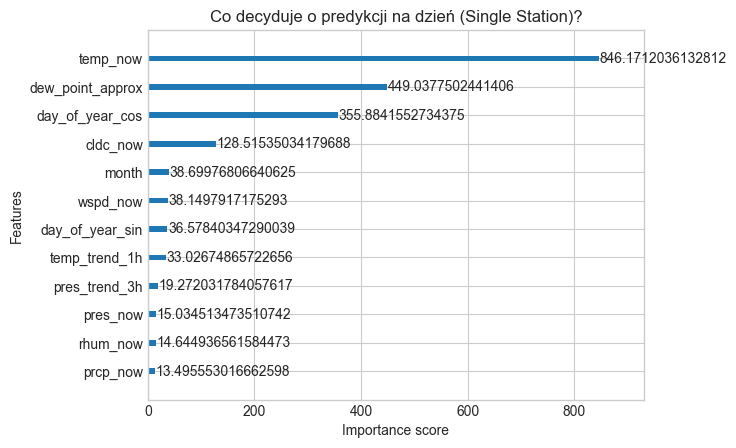

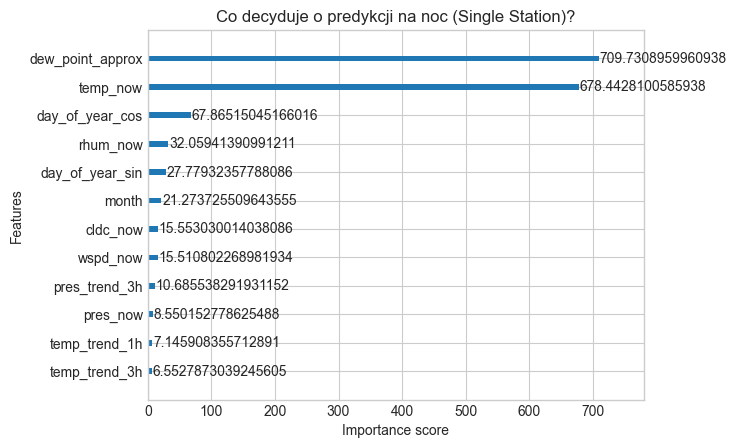

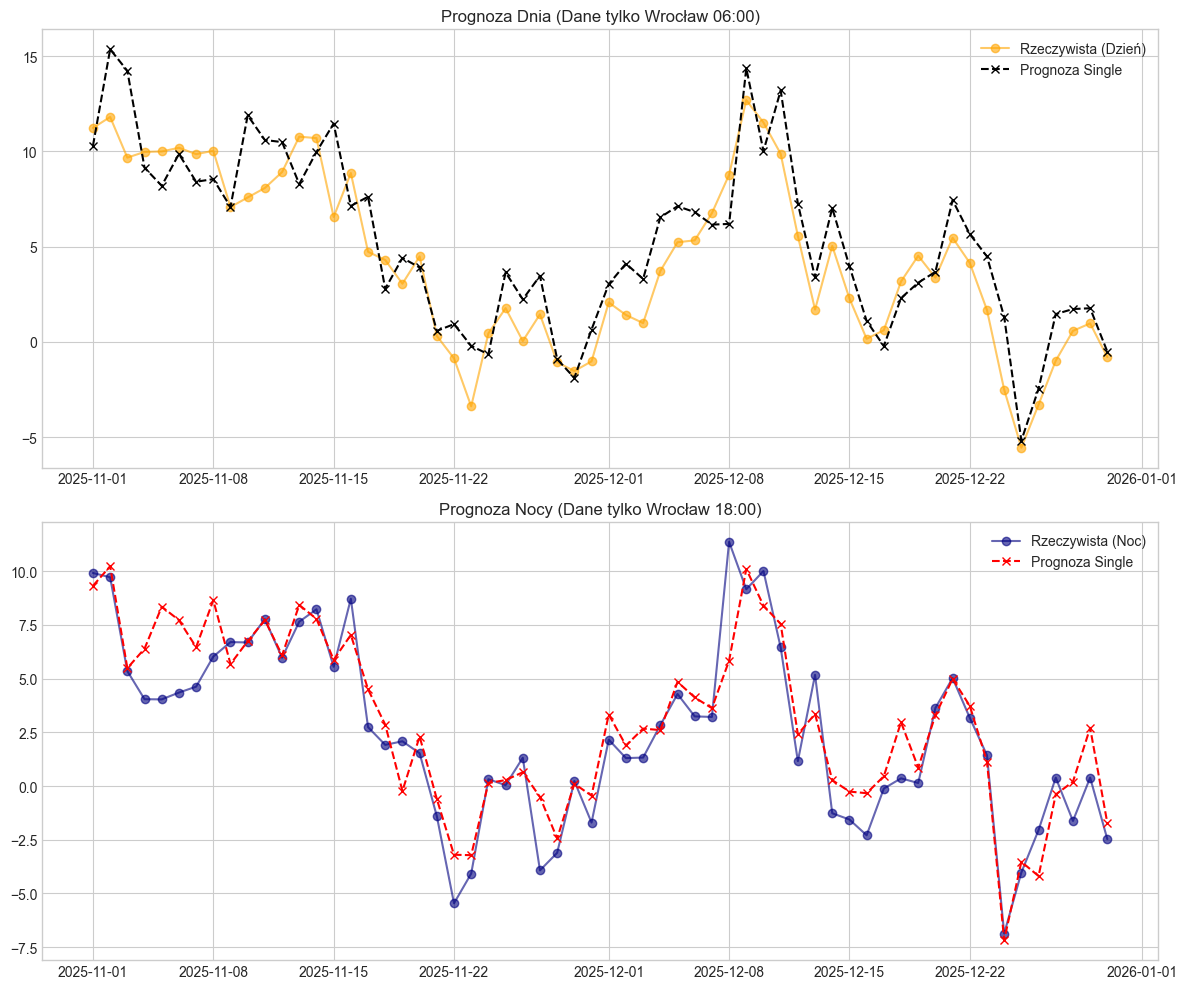

<Figure size 1000x500 with 0 Axes>

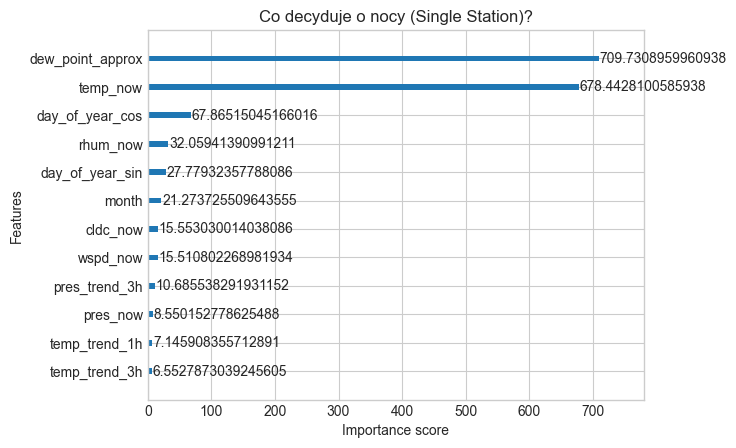

In [62]:
day_results = train_and_eval(data_day, "target_temp_day", "MODEL DNIA")
night_results = train_and_eval(data_night, "target_temp_night", "MODEL NOCY")

modal_day = day_results[2]
xgb.plot_importance(
    modal_day,
    max_num_features=12,
    importance_type="gain",
    title="Co decyduje o predykcji na dzień (Single Station)?",
)

model_night = night_results[2]
xgb.plot_importance(
    model_night,
    max_num_features=12,
    importance_type="gain",
    title="Co decyduje o predykcji na noc (Single Station)?",
)
plt.show()

show_results(day_results, night_results)

Wariant z większą ilością lag features
(ale więcej features wcale nie poprawiło wyniku)

In [63]:
def create_single_station_dataset_big(df, snapshot_hour, target_series):
    df = df.copy()
    df = df[df.index.hour <= snapshot_hour]

    base_cols = ["temp", "pres", "rhum", "wspd", "prcp"]
    df_base = df[base_cols]

    X = pd.DataFrame(index=df.index)

    # 1. LAG FEATURES
    lags = [1, 3, 6, 12, 24]

    for col in ["temp", "pres", "rhum", "wspd"]:
        for lag in lags:
            X[f"{col}_lag_{lag}h"] = df_base[col].shift(lag)

    # 2. TRENDS (DIFFERENCES)
    X["temp_trend_3h"] = df_base["temp"] - df_base["temp"].shift(3)
    X["temp_trend_12h"] = df_base["temp"] - df_base["temp"].shift(12)

    X["pres_trend_6h"] = df_base["pres"] - df_base["pres"].shift(6)
    X["pres_trend_24h"] = df_base["pres"] - df_base["pres"].shift(24)

    # 3. ROLLING STATS
    for win in [6, 24]:
        X[f"temp_mean_{win}h"] = df_base["temp"].shift(1).rolling(win).mean()
        X[f"temp_std_{win}h"] = df_base["temp"].shift(1).rolling(win).std()

        X[f"pres_mean_{win}h"] = df_base["pres"].shift(1).rolling(win).mean()
        X[f"pres_std_{win}h"] = df_base["pres"].shift(1).rolling(win).std()

    # 4. WILGOTNOŚĆ / PUNKT ROSY
    X["dew_point_approx"] = df_base["temp"] - ((100 - df_base["rhum"]) / 5)

    # 5. CZAS (CYKLICZNY)
    idx = df.index
    X["day_year_sin"] = df["day_year_sin"]
    X["day_year_cos"] = df["day_year_cos"]
    X["month"] = df["month"]
    wdir = df['wdir']
    df['wdir_sin'] = np.sin(np.deg2rad(wdir))
    df['wdir_cos'] = np.cos(np.deg2rad(wdir))

    X = X[X.index.hour == snapshot_hour]
    X.index = X.index.normalize()
    data = X.join(target_series, how="inner")
    return data

[MODEL DNIA] RMSE: 2.67°C | MAE: 2.11°C | R2: 0.8954
[MODEL NOCY] RMSE: 1.48°C | MAE: 1.15°C | R2: 0.9545


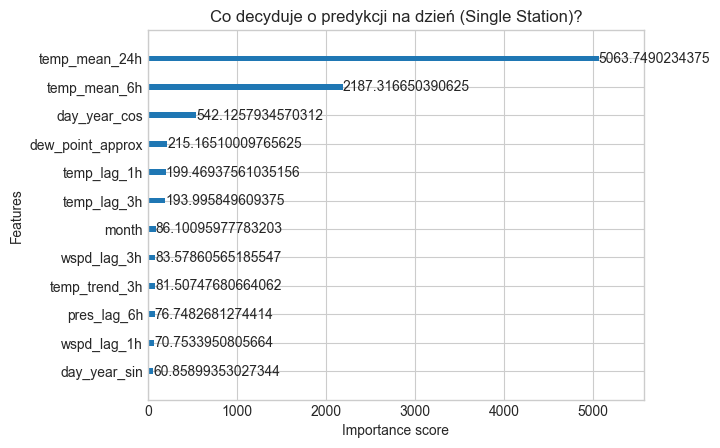

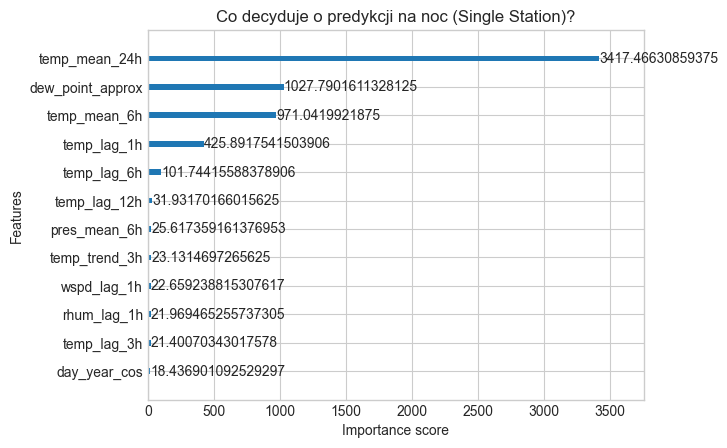

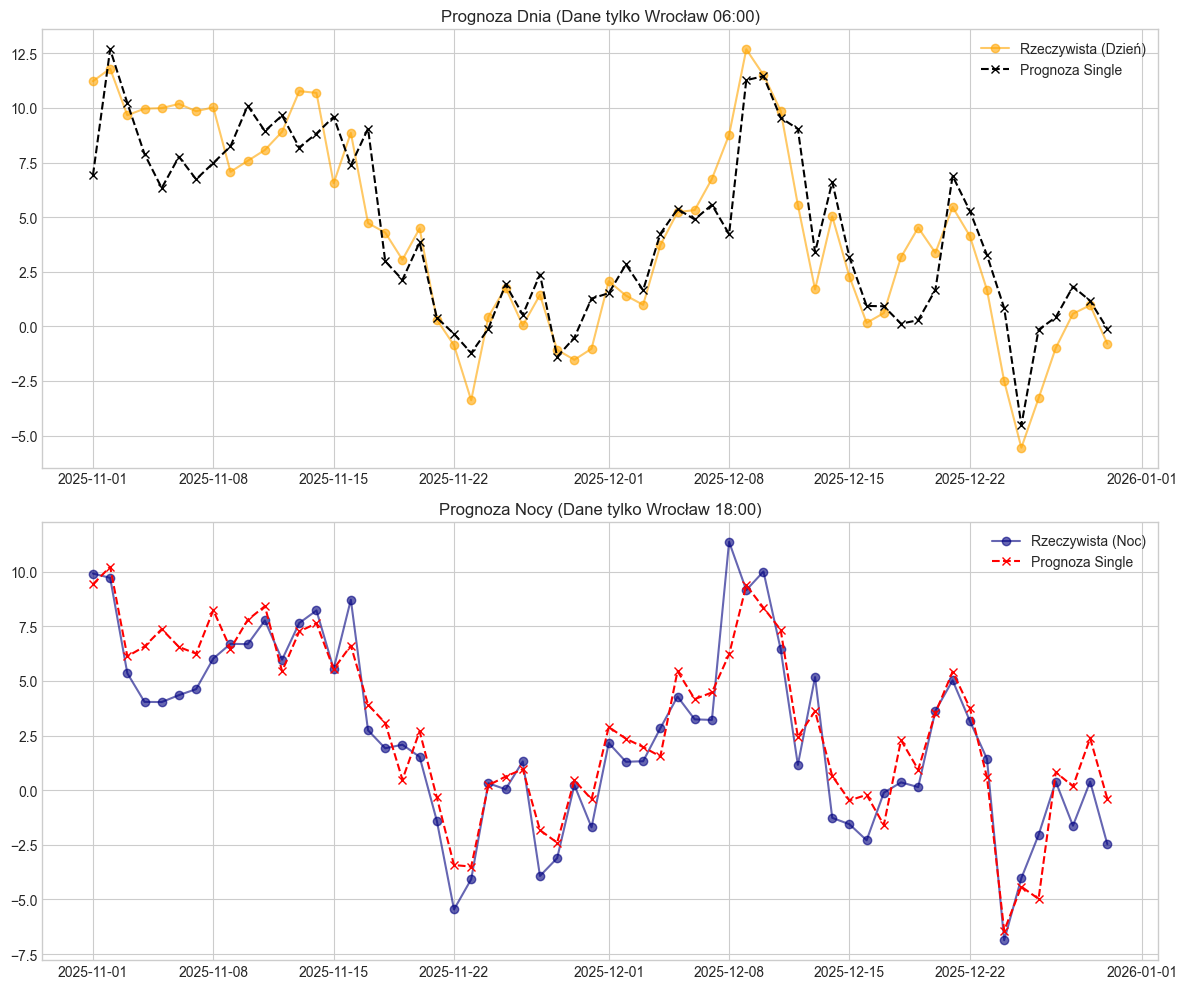

<Figure size 1000x500 with 0 Axes>

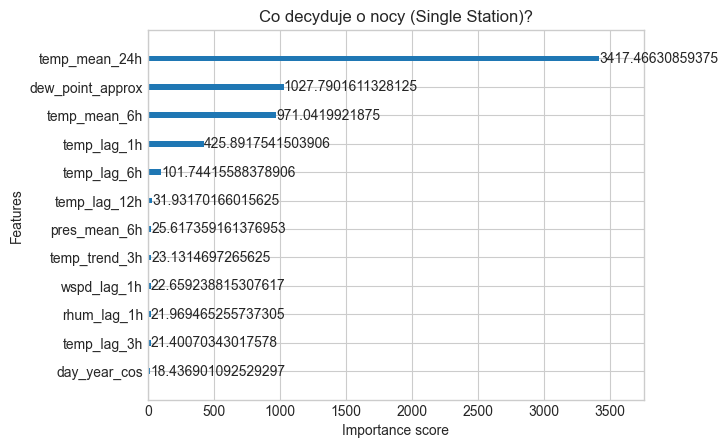

In [64]:
data_day = create_single_station_dataset_big(df, snapshot_hour=5, target_series=series_day_target)
data_night = create_single_station_dataset_big(df, snapshot_hour=17, target_series=series_night_target)

day_results = train_and_eval(data_day, 'target_temp_day', 'MODEL DNIA')
night_results = train_and_eval(data_night, 'target_temp_night', 'MODEL NOCY')

modal_day = day_results[2]
xgb.plot_importance(modal_day, max_num_features=12, importance_type='gain', title='Co decyduje o predykcji na dzień (Single Station)?')

model_night = night_results[2]
xgb.plot_importance(model_night, max_num_features=12, importance_type='gain', title='Co decyduje o predykcji na noc (Single Station)?')
plt.show()

show_results(day_results, night_results)


### XGBoost z danymi z sąsiednich stacji

In [66]:
def create_specialized_dataset(df_raw, snapshot_hour, target_series, neighbor_cities):
    """
    Tworzy dataset, gdzie cechami jest stan pogody o konkretnej godzinie (snapshot),
    a celem jest średnia temperatura nadchodzącego okresu.
    """
    print(f"\n--- Budowanie datasetu dla Snapshota: {snapshot_hour}:00 ---")

    # 1. Pobieramy tylko wiersze z godziny snapshota
    df_snap = df_raw[df_raw.index.hour == snapshot_hour].copy()

    # Normalizujemy indeks do północy, żeby móc połączyć z targetami po dacie
    df_snap.index = df_snap.index.normalize()

    # 2. Budowa cech (Features)
    X = pd.DataFrame(index=df_snap.index)

    # Baza (Wrocław)
    X['temp_start'] = df_snap['temp']
    X['pres_start'] = df_snap['pres']
    X['rhum_start'] = df_snap['rhum']
    X['wspd_start'] = df_snap['wspd']

    # Trend ciśnienia (Snapshot - 6h wcześniej)
    # Np. dla 06:00 sprawdzamy ciśnienie o 00:00
    prev_hour = (snapshot_hour - 6) % 24
    df_prev = df_raw[df_raw.index.hour == prev_hour].copy()
    df_prev.index = df_prev.index.normalize()
    # Musimy uważać na daty przy przejściu przez północ, ale normalize() i join załatwi sprawę
    # (Dla uproszczenia w tym kodzie pomijam idealne dopasowanie -6h jeśli zmienia się data,
    #  zostajemy przy prostych cechach snapshotowych i gradientach)

    # Sąsiedzi (Gradienty przestrzenne) - KLUCZOWE
    for city in neighbor_cities:
        col_t = f'temp_{city}'
        col_p = f'pres_{city}'
        if col_t in df_snap.columns:
            X[f'diff_temp_{city}'] = df_snap[col_t] - df_snap['temp'] # Czy tam jest cieplej?
        if col_p in df_snap.columns:
            X[f'diff_pres_{city}'] = df_snap[col_p] - df_snap['pres'] # Skąd wieje wiatr (geostroficzny)?

    # Czas
    X['day_of_year_sin'] = np.sin(2 * np.pi * X.index.dayofyear / 365)
    X['day_of_year_cos'] = np.cos(2 * np.pi * X.index.dayofyear / 365)

    # 3. Łączenie z Celem
    data = pd.concat([X, target_series], axis=1).dropna()

    return data



--- Budowanie datasetu dla Snapshota: 5:00 ---

--- Budowanie datasetu dla Snapshota: 17:00 ---
[MODEL DNIA] RMSE: 2.04°C | MAE: 1.58°C | R2: 0.9386
[MODEL NOCY] RMSE: 1.49°C | MAE: 1.18°C | R2: 0.9538


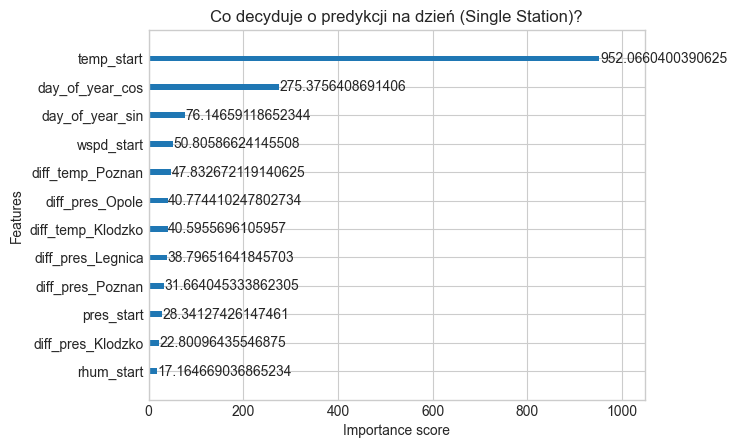

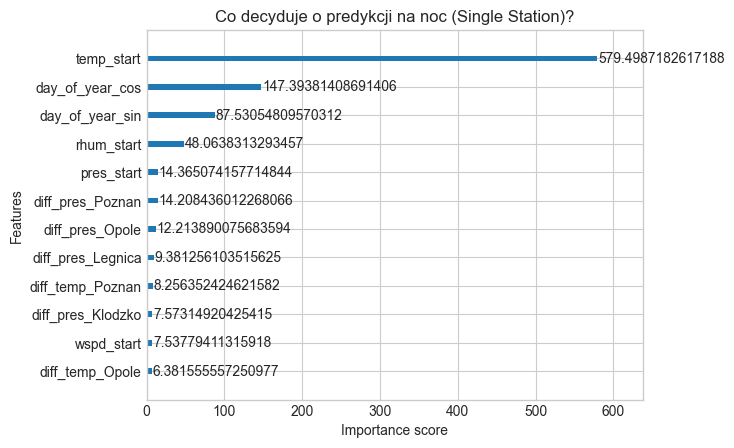

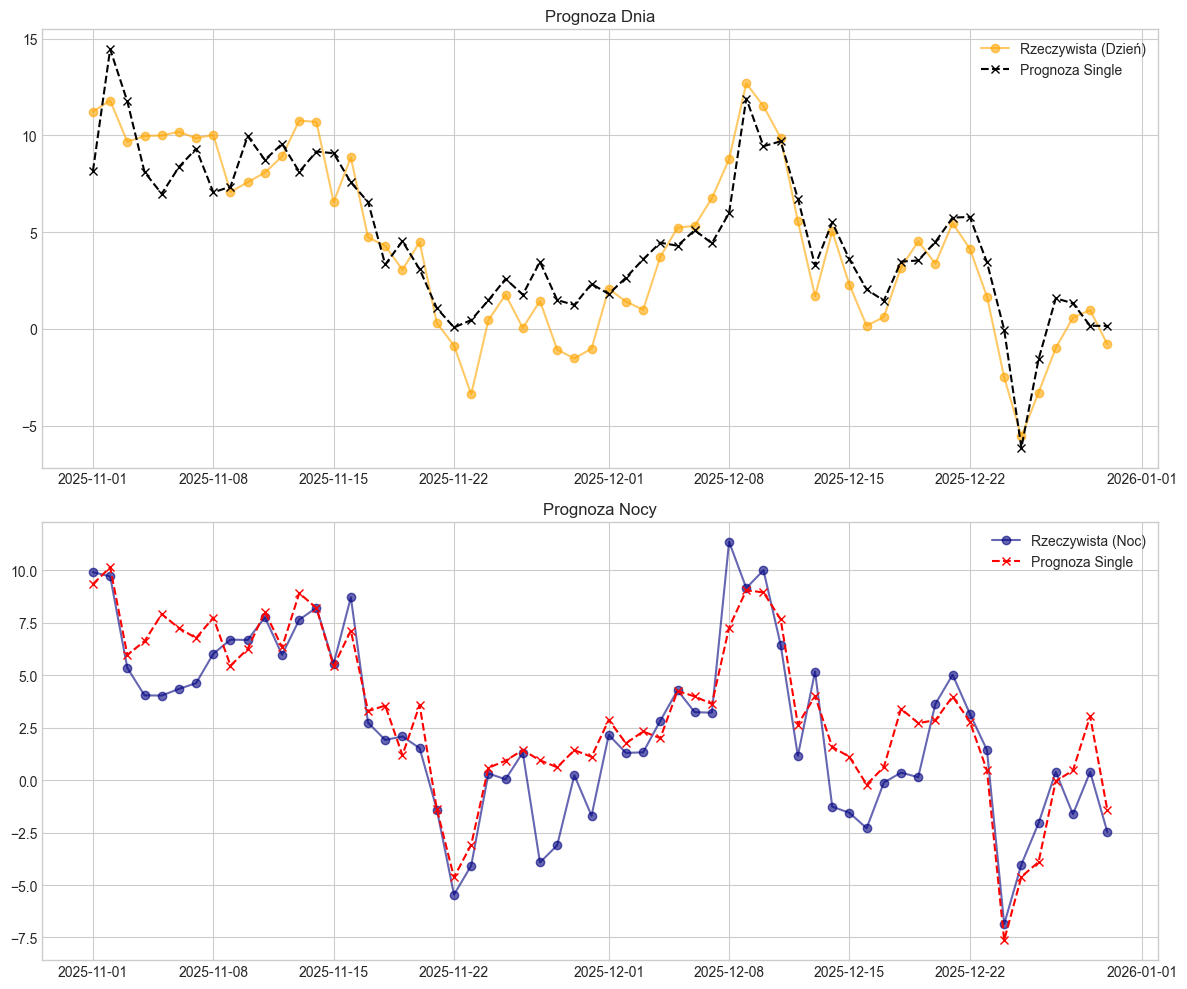

In [68]:

cities = ['Legnica', 'Opole', 'Poznan', 'Klodzko']

# === DATASET 1: PORANNY (Prognoza Dnia) ===
# Snapshot o 05:00 rano -> Przewidujemy średnią z 06:00-18:00
data_day = create_specialized_dataset(df, snapshot_hour=5, target_series=series_day_target, neighbor_cities=cities)

# === DATASET 2: WIECZORNY (Prognoza Nocy) ===
# Snapshot o 17:00 wieczorem -> Przewidujemy średnią z 18:00-06:00
data_night = create_specialized_dataset(df, snapshot_hour=17, target_series=series_night_target, neighbor_cities=cities)

day_results = train_and_eval(data_day, 'target_temp_day', 'MODEL DNIA')
night_results = train_and_eval(data_night, 'target_temp_night', 'MODEL NOCY')

modal_day = day_results[2]
xgb.plot_importance(modal_day, max_num_features=12, importance_type='gain', title='Co decyduje o predykcji na dzień (Single Station)?')

model_night = night_results[2]
xgb.plot_importance(model_night, max_num_features=12, importance_type='gain', title='Co decyduje o predykcji na noc (Single Station)?')
plt.show()

show_results(day_results, night_results)